### Put all import statement here 

In [294]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plot
import imageio
%matplotlib inline

### 1) Create method to extract contours
- First generic method to extract contours and sort by the size
- Second method to extract largest contour
- Third method to extract second largest contour
- Forth method to extract all digit contours 

In [392]:
def extractContours(image, lower, upper):
    bounds = []
    areaArray = []
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    ret,thresh = cv2.threshold(mask, 40, 255, 0)
    im2,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        areaArray.append(area)
 
    sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)
    
    for con in sorteddata:
        x,y,w,h = cv2.boundingRect(con[1])
        bounds.append([x,y,w,h])

    return bounds

In [393]:
def extractLargestContours(image, lower, upper): 
    bound = extractContours(image, lower, upper)
    x = bound[0][0];
    y = bound[0][1];
    w = bound[0][2];
    h = bound[0][3];
    return image[y:y+h, x:x+w]


In [394]:
def extractSecondLargestContours(image, lower, upper): 
    bound = extractContours(image, lower, upper)
    x = bound[1][0];
    y = bound[1][1];
    w = bound[1][2];
    h = bound[1][3];
    return image[y:y+h, x:x+w]


In [395]:
def extractDigit(image, lower, upper): 
    areas = extractContours(image, lower, upper)
    areas = sorted(areas,key=lambda a:a[0], reverse=False)
    imgDigits = []
    for area in areas:
        x = area[0] - 4
        y = area[1] - 4
        w = area[2] + 8
        h = area[3] + 8
        imgDigit = image[y:y+h, x:x+w]
        if imgDigit.shape[0] >= 3 and imgDigit.shape[1] >= 3:    
            imgDigit = cv2.resize(imgDigit, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)  
            imgDigit = np.where (imgDigit / 255 <= 0.55, 1.0, 0.0)
            imgDigits.append(imgDigit)
    return imgDigits

Method to extract rgb into gray and store in a file

In [396]:
def storeRgb2Gray(rgb, filename):
    temp = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    plot.imsave(filename,temp, cmap = plot.get_cmap('gray'))

. To mimic a real-life situation, a cheque template is created for this project, then we manually write the amount, date and account number. After that, both side of cheque will be captured by phone’s camera. In banking industry, they use scanner to scan a cheque into system. It should provide clearer image than camera photo without affecting by light condition. We do not have such device in this project, so we wil stick with the phone’s camera. <br> <br>
First, we start with the front side of the cheque. We are interested in two particular parts: date and amount field. Both have same background i.e. gray color.  Due to the camera and brightness issue, the top and bottom of cheque were white color, but it shows in gray color. We need to filter out the top and bottom and retain the middle yellow color only. This can be done by using find contour in opencv. We can filter out the interested area by using mask. The mask here is in yellow color 

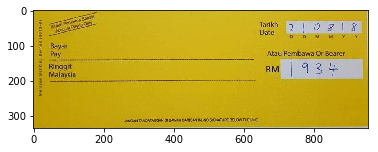

In [478]:
image = cv2.imread("testchequefront.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# define the list of boundaries
lower = np.array([50, 10, 10], dtype = "uint8")
upper = np.array([255, 240, 80], dtype = "uint8")
imgCheque = extractLargestContours(image, lower, upper)
plot.imshow(imgCheque)

For back side, we are interested in the account number. <br><br>First we find the largest contour with yellow mask, then find the second largest contour with gray mask. The reason to choose second largest is because the largest box in gray area is the region for bank to write something. 

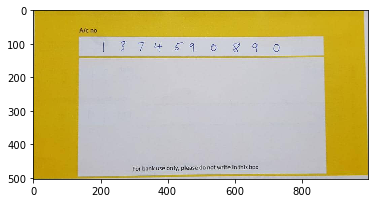

In [480]:
imageback = cv2.imread("testchequeback.jpeg")
imageback = cv2.cvtColor(imageback, cv2.COLOR_BGR2RGB)
# define the list of boundaries
lower = np.array([50, 10, 10], dtype = "uint8")
upper = np.array([255, 240, 80], dtype = "uint8")
imgChequeBack = extractLargestContours(imageback, lower, upper)
plot.imshow(imgChequeBack)

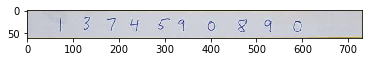

In [479]:
lower = np.array([150, 150, 150], dtype = "uint8")
upper = np.array([255, 255, 255], dtype = "uint8")
imgAccNo = extractSecondLargestContours(imgChequeBack, lower, upper)
plot.imshow(imgAccNo)

Back to the front side of cheque. By using find contour with gray mask, the largest contour is the amount field, and second largest contour is the date field

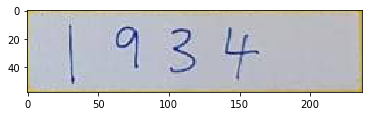

In [481]:
lower = np.array([100, 100, 100], dtype = "uint8")
upper = np.array([255, 255, 255], dtype = "uint8")
imgAmount = extractLargestContours(imgCheque, lower, upper)
plot.imshow(imgAmount)

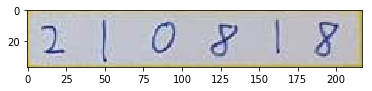

In [482]:
imgDate = extractSecondLargestContours(imgCheque, lower, upper)
plot.imshow(imgDate)

Now we convert all 3 images into grayscale

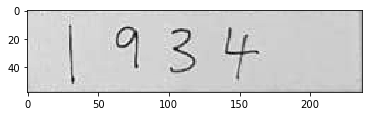

In [483]:
storeRgb2Gray(imgAmount, "imgAmountGray.jpg")
imgAmount1 = cv2.imread("imgAmountGray.jpg")
plot.imshow(imgAmount1)

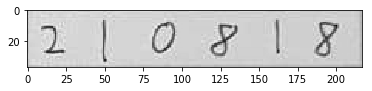

In [484]:
storeRgb2Gray(imgDate, "imgDateGray.jpg")
imgDate1 = cv2.imread("imgDateGray.jpg")
plot.imshow(imgDate1)

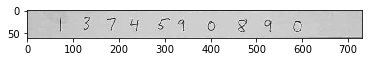

In [485]:
storeRgb2Gray(imgAccNo, "imgAccNoGray.jpg")
imgAccNo1 = cv2.imread("imgAccNoGray.jpg")
plot.imshow(imgAccNo1)

Our CNN model was trained by using MNIST dataset i.e. the digit in white and background in black color <br> <br>
Now we convert our images into that pattern

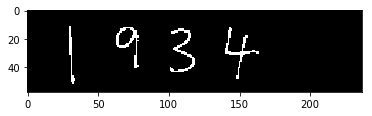

In [487]:
imgAmount2 = np.where (imgAmount1 / 255 <= 0.55, 1.0, 0.0)
plot.imshow(imgAmount2)

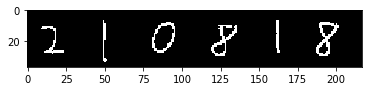

In [488]:
imgDate2 = np.where (imgDate1 / 255 <= 0.55, 1.0, 0.0)
plot.imshow(imgDate2)

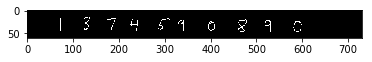

In [489]:
imgAccNo2 = np.where (imgAccNo1 / 255 <= 0.51, 1.0, 0.0)
plot.imshow(imgAccNo2)

Now we are going to extract individual digit from the image. By using find contour, we will know how many digits in an image. Furthermore, we filter out image that is smaller than 3x3 and sort them based on x axis. This will be done in the method extractDigit. Moreover, all images will be resized into 28x28 to match with the size of MNIST images

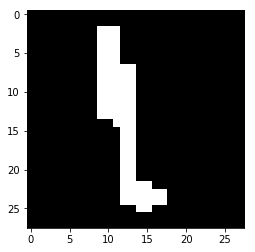

In [505]:
imgAmount3 = np.where(imgAmount2 == 0., 255.0, 3.0)
lower = np.array([0, 0, 0], dtype = "uint8")
upper = np.array([10, 10, 10], dtype = "uint8")
imgDigitAmounts = extractDigit(imgAmount3, lower, upper)
plot.imshow(imgDigitAmounts[0])

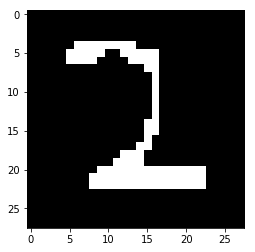

In [502]:
imgDate3 = np.where(imgDate2 == 0., 255.0, 3.0)
imgDateAmounts = extractDigit(imgDate3, lower, upper)
plot.imshow(imgDateAmounts[0])

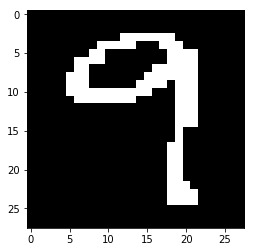

In [506]:
imgAccNo3 = np.where(imgAccNo2 == 0., 255.0, 3.0)
imgAccNoAmounts = extractDigit(imgAccNo3, lower, upper)
plot.imshow(imgAccNoAmounts[5])

All individual digits are extracted into seperate image. Now we can start to do our prediction. 

In [496]:
import os
import uuid
#force to use cpu in jupyter notebook, due to GPU memory allocation issue in jupypter
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from keras.models import Sequential
from keras.models import load_model

Load the train model from previous session 

In [497]:
model = load_model("mnist_rounded.h5")

To put this data into Keras CNN model, we need to convert it into numpy array. 

In [499]:
def createNumpyImages(imgs):
    npImg = np.empty([len(imgs), 28,28])
    i = 0
    for img in imgs:
        uid = uuid.uuid4()
        filename = "cheque_digits/" + str(uid) + ".jpg"
        plot.imsave(filename,img, cmap = plot.get_cmap('gray'))
        imgDAGray = imageio.imread(filename, as_gray=True)
        npImg[i] = imgDAGray
        i= i + 1
    print(npImg.shape)
    npImg = np.expand_dims(npImg, axis=3)
    print(npImg.shape)
    return npImg

In [475]:
npImgDA = createNumpyImages(imgDigitAmounts)
npImgDaA = createNumpyImages(imgDateAmounts)
npImgAN = createNumpyImages(imgAccNoAmounts)

(4, 28, 28)
(4, 28, 28, 1)
(6, 28, 28)
(6, 28, 28, 1)
(10, 28, 28)
(10, 28, 28, 1)


### Prediction result.

Amount: Actual (1934), Predicted (1734) <br>
Date: Actual (210818), Predicted (210818) <br>
Acc No : Actual (1374590890), Predicted (1374570890)<br>

From the result, we can see that this model has issue in predicting 9. It misclassified two of the '9' into '7'. To improve this result, we can put more training data for '9'. **The overall performance in this experiment is 18/20 = 0.9**

In [476]:
resultDA = model.predict(npImgDA)
predYDA = np.argmax(resultDA, axis=1)
print(predYDA)

resultDaA = model.predict(npImgDaA)
predYDaA = np.argmax(resultDaA, axis=1)
print(predYDaA)

resultAN = model.predict(npImgAN)
predAN = np.argmax(resultAN, axis=1)
print(predAN)

[1 7 3 4]
[2 1 0 8 1 8]
[1 3 7 4 5 7 0 8 9 0]
